# RFM Segmentation with python (The Data analytics approach to gain customer insights.)

## Import required libraries 

In [3]:
# importing required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from utils.config import config

## Download or import transaction data and customer data

In [4]:

transact_data_file = config.get('INPUT','transaction_data',
                                 fallback='./data/input/customer_transaction_data.csv')

customer_data_file = config.get('INPUT','customer_data',
                                 fallback='./data/input/customer_data.csv')

df_customer = pd.read_csv(customer_data_file, on_bad_lines='skip')
df_transactions = pd.read_csv(transact_data_file, parse_dates=['transactionDate'], on_bad_lines='skip')

In [5]:
df_customer.info()
df_customer.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customerID                     2000 non-null   int64 
 1   customerName                   2000 non-null   object
 2   customerAge                    2000 non-null   int64 
 3   customerGender                 2000 non-null   object
 4   customerLocation               2000 non-null   object
 5   customerEducation              2000 non-null   object
 6   customerIndustry               2000 non-null   object
 7   customerAuthorizedSignatories  2000 non-null   object
dtypes: int64(2), object(6)
memory usage: 125.1+ KB


,customerID,customerAge
count,2.000000e+03,2000.000000
mean,5.528466e+07,53.263000
std,2.657936e+07,15.891542
min,1.005268e+07,20.000000
25%,3.172595e+07,42.000000
50%,5.526722e+07,55.000000
75%,7.891956e+07,66.000000
max,9.991442e+07,80.000000


In [6]:
df_transactions.info()
df_transactions.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143860 entries, 0 to 143859
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   transactionReference  143860 non-null  object        
 1   transactionDate       143860 non-null  datetime64[ns]
 2   payeeAccountNumber    143860 non-null  int64         
 3   payeeName             143860 non-null  object        
 4   payeeIndustry         0 non-null       float64       
 5   transactionCode       143860 non-null  object        
 6   amount                143860 non-null  float64       
 7   indicator             143860 non-null  object        
 8   transferNotes         116238 non-null  object        
 9   transactionCategory   143860 non-null  object        
 10  customerID            143860 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 12.1+ MB


,payeeAccountNumber,payeeIndustry,amount,customerID
count,1.438600e+05,0.0,143860.000000,1.438600e+05
mean,5.002643e+09,NaN,3985.403875,5.420397e+07
std,2.890382e+09,NaN,3092.316000,2.647476e+07
min,7.101500e+04,NaN,100.120000,1.005268e+07
25%,2.496311e+09,NaN,870.645000,3.026934e+07
50%,5.009892e+09,NaN,3531.240000,5.304404e+07
75%,7.509203e+09,NaN,6646.430000,7.793829e+07
max,9.999969e+09,NaN,9998.520000,9.991442e+07


## Data Preparation

In [7]:
df_customer[df_customer.duplicated()].any()

customerID                       False
customerName                     False
customerAge                      False
customerGender                   False
customerLocation                 False
customerEducation                False
customerIndustry                 False
customerAuthorizedSignatories    False
dtype: bool

In [8]:
df_transactions[df_transactions.duplicated()].any()

transactionReference    False
transactionDate         False
payeeAccountNumber      False
payeeName               False
payeeIndustry           False
transactionCode         False
amount                  False
indicator               False
transferNotes           False
transactionCategory     False
customerID              False
dtype: bool

## Data Cleaning

In [9]:
#Data Cleaning for customers 

#Dropping Duplicates
df_customer.drop_duplicates(inplace=True)
generations = lambda age: 'Gen Z' if age <= 24 else 'Millennials' if age <= 40 else 'Gen X' if age <= 55 else 'Baby Boomers' if age <= 75 else 'Silent Generation'
df_customer['customerGeneration'] = df_customer['customerAge'].apply(generations)
state = lambda x: x.split(",")[-1].split()[0] if len(x.split(",")[-1].split()) == 2 else None
df_customer['customerState'] = df_customer['customerLocation'].apply(state)

#Data cleaning for transactions 
df_transactions.drop_duplicates(inplace=True)
df_transactions = df_transactions[df_transactions['customerID'].isin(df_customer['customerID'])]
df_transactions['amount'] = df_transactions['amount'].apply(abs)


In [10]:
#Checking if duplicates have been dropped
df_transactions[df_transactions.duplicated()].any()

transactionReference    False
transactionDate         False
payeeAccountNumber      False
payeeName               False
payeeIndustry           False
transactionCode         False
amount                  False
indicator               False
transferNotes           False
transactionCategory     False
customerID              False
dtype: bool

In [11]:
#Checking for the number of unique Customers
df_transactions['customerID'].nunique()

2000

In [12]:
# Checking for the total number of transaction records
df_transactions.shape

(143860, 11)

In [13]:
# Checking for the max and min InvoiceData inorder to calculate number of months of data available
print('Min:{}; max:{}'.format(min(df_transactions.transactionDate),max(df_transactions.transactionDate)))

Min:2021-04-21 00:00:00; max:2023-04-20 00:00:00


# Cohort Analysis

Descriptive analytics tool used to group customers into mutually exclusive cohorts measured over time. Helps understand high level trends better by providing insight on metrics across products ans Customer life cycle.

## Assign Acquisition Month Cohort to each Customer
Assumption: Considert first transactionDate as acquisition date

In [14]:
# Define a function that will parse the date, it truncates given date obect to the first day of the month
def get_month(x): return dt.datetime(x.year, x.month, 1) 

# Apply get_month method to transactionDate and create acquisitionDate Column
df_transactions['acquisitionDate'] = df_transactions['transactionDate'].apply(get_month) 

# Create groupby Obj with customerID & use acquisitionDate column for further Manipulation
grouping = df_transactions.groupby('customerID')['acquisitionDate'] 

# Finally Transform with min function to assign the smallest acquisitionDate Value to each Customer in the DataSet
df_transactions['cohort'] = grouping.transform('min')

In [15]:
#Extract integer values from the data
def get_date_int(data,column):
    year=data[column].dt.year
    month=data[column].dt.month
    day=data[column].dt.day
    return year, month, day

In [16]:
# Assign Time Offset Value
invoice_year, invoice_month, _=get_date_int(df_transactions,'acquisitionDate')
cohort_year, cohort_month,_=get_date_int(df_transactions,'cohort')
year_diff= invoice_year-cohort_year
month_diff=invoice_month-cohort_month
#+1 for first month to be marked as one instead of 0 for better interpretetation
df_transactions['CohortIndex']= (year_diff*12) + (month_diff+1)
#check if the new column has been added. CohortIndex
df_transactions.head()

,transactionReference,transactionDate,payeeAccountNumber,payeeName,payeeIndustry,transactionCode,amount,indicator,transferNotes,transactionCategory,customerID,acquisitionDate,cohort,CohortIndex
0,85ad9f8bd7c549bbb94b86ccd211f265,2021-08-18,3551605690,Andrew Norris,NaN,IB,601.33,CR,,Other Incoming,25965788,2021-08-01,2021-04-01,5
1,99518c033c4c4b4aa06c75dc41a071cd,2022-03-15,5139454222,Orozco Group Public Relations and Sons,NaN,MB,3665.39,DB,newspapaer advertisement,Marketing,25965788,2022-03-01,2021-04-01,12
2,81841272e90a4ca68adff3bf47d9d458,2022-07-04,4392428226,"Scott, Williams and Simpson Learning Group",NaN,MB,7458.17,DB,NaN,Employee training,25965788,2022-07-01,2021-04-01,16
3,031026f67bcc4843b48a1a5287706f44,2022-02-22,8952688343,Elizabeth Nelson,NaN,GIRO,354.32,CR,,Interest Income,25965788,2022-02-01,2021-04-01,11
4,cb1fac0057894d4cb61d89e029af8620,2023-03-16,3810661586,Hall-Casey Electric Group,NaN,NETS,9859.33,DB,,Utilities,25965788,2023-03-01,2021-04-01,24


In [17]:
grouping = df_transactions.groupby(['cohort', 'CohortIndex'])

cohort_data = grouping['customerID'].apply(pd.Series.nunique)

cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='cohort',
                                 columns='CohortIndex',
                                 values='customerID')
display(cohort_counts)

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohort,,,,,,,,,,,,,,,,,,,,,
2021-04-01,459.0,431.0,429.0,438.0,422.0,430.0,407.0,277.0,277.0,277.0,...,277.0,277.0,277.0,277.0,277.0,277.0,277.0,277.0,277.0,275.0
2021-05-01,214.0,176.0,178.0,174.0,179.0,154.0,23.0,23.0,23.0,23.0,...,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,23.0,NaN
2021-06-01,45.0,15.0,16.0,16.0,14.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,723.0,686.0,681.0,681.0,684.0,686.0,685.0,674.0,682.0,683.0,...,684.0,683.0,684.0,685.0,674.0,687.0,659.0,NaN,NaN,NaN
2021-08-01,34.0,10.0,10.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,...,10.0,10.0,9.0,10.0,10.0,9.0,NaN,NaN,NaN,NaN
2021-09-01,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01,210.0,163.0,160.0,162.0,165.0,161.0,163.0,161.0,169.0,159.0,...,161.0,159.0,159.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01,146.0,107.0,109.0,112.0,112.0,114.0,115.0,109.0,111.0,109.0,...,107.0,115.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,31.0,6.0,7.0,7.0,7.0,7.0,7.0,6.0,7.0,7.0,...,7.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention.index=retention.index.date
retention.round(3)*100

CohortIndex,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
2021-04-01,100.0,93.9,93.5,95.4,91.9,93.7,88.7,60.3,60.3,60.3,...,60.3,60.3,60.3,60.3,60.3,60.3,60.3,60.3,60.3,59.9
2021-05-01,100.0,82.2,83.2,81.3,83.6,72.0,10.7,10.7,10.7,10.7,...,10.7,10.7,10.7,10.7,10.7,10.7,10.7,10.7,10.7,NaN
2021-06-01,100.0,33.3,35.6,35.6,31.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,100.0,94.9,94.2,94.2,94.6,94.9,94.7,93.2,94.3,94.5,...,94.6,94.5,94.6,94.7,93.2,95.0,91.1,NaN,NaN,NaN
2021-08-01,100.0,29.4,29.4,29.4,29.4,29.4,26.5,29.4,29.4,29.4,...,29.4,29.4,26.5,29.4,29.4,26.5,NaN,NaN,NaN,NaN
2021-09-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-01,100.0,77.6,76.2,77.1,78.6,76.7,77.6,76.7,80.5,75.7,...,76.7,75.7,75.7,69.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-01,100.0,73.3,74.7,76.7,76.7,78.1,78.8,74.7,76.0,74.7,...,73.3,78.8,69.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-01,100.0,19.4,22.6,22.6,22.6,22.6,22.6,19.4,22.6,22.6,...,22.6,19.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


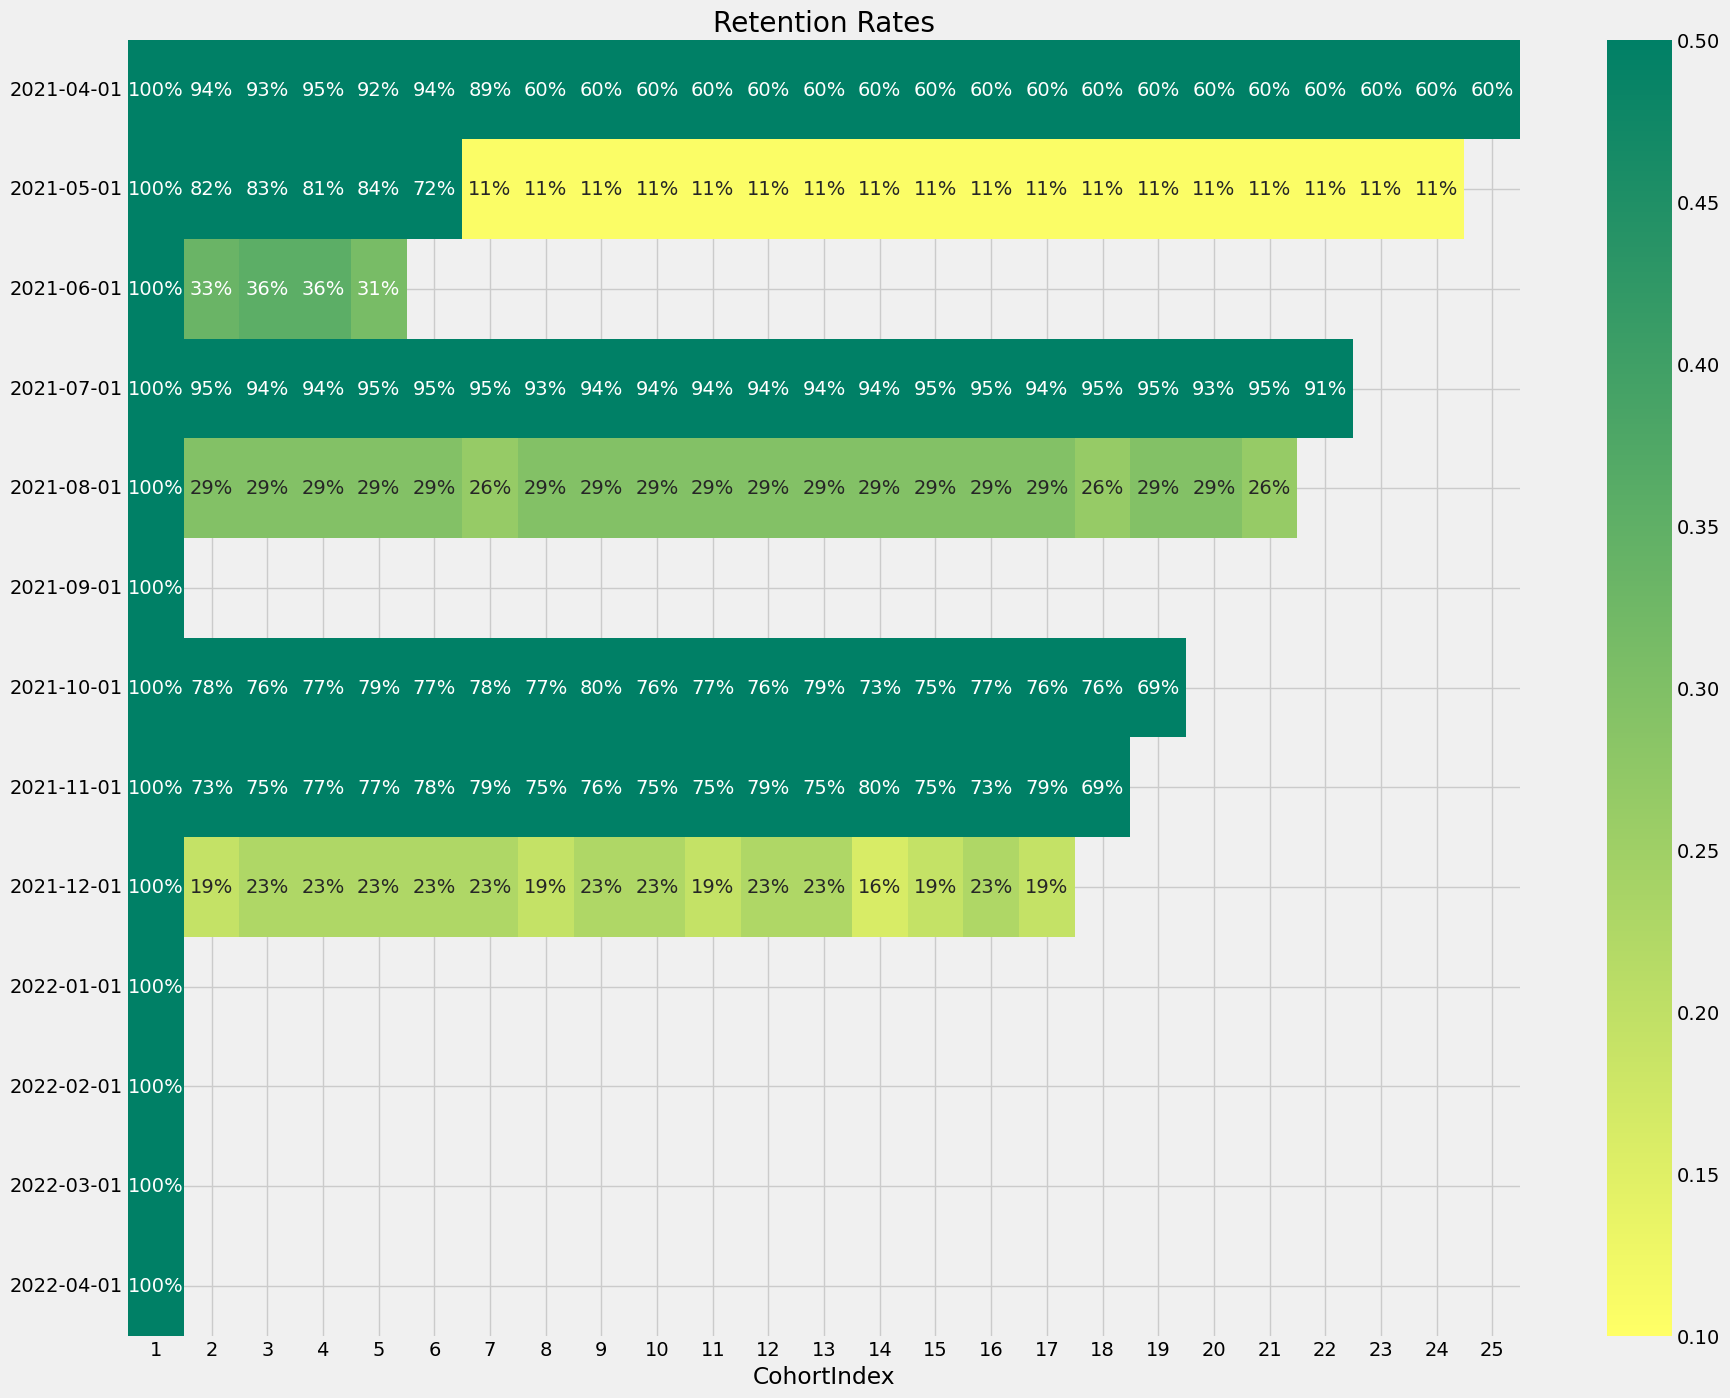

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#sns.set()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,16))
plt.title('Retention Rates')

sns.heatmap(data = retention,
           annot = True,
           fmt = '.0%',
           vmin= 0.1,
           vmax=0.5,
           cmap='summer_r')
plt.show()

# RFM Segmentation 

Recency (R) : Days Since Last Customer Transaction
Frequency (F): Number of transacations in the last 12 months
Monetary Value (M) : Total Spend in the last 12 months

# RFM Data Preperation

 Pandas built-in function #qcut will be used to calculate percentiles
 
To implement RFM Segmentation, we need to further process the data set in by the following steps:

Recency : For each customer ID, calculate the days since the last transaction. Create a hypothetical date maximum Date +1 to make it seem as though we are working on the most recent data substract the max Date of transaction(Most recent date of transation) of the customer. However, usually the data used is Real time data and using the present date would be ideal. 
Frequency: Count the number of invoices per customer to derive the frequency and 
Monetary Data: Sum the amount of money a customer transacted and divide it by Frequency, to get the amount per transaction on average, that is the Monetary data.

In [20]:
# create hypothetical snapshot_day as if anlysisng the most recent data
snapshot=max(df_transactions.transactionDate)+dt.timedelta(days=1)

In [21]:
datamart=df_transactions.groupby(['customerID']).agg({
    'transactionDate':lambda x:(snapshot-x.max()).days,
    'transactionReference':'count',
    'amount':'sum'
})

In [22]:
# Rename columns for easy interpretation
datamart.rename(columns={'transactionDate':'Recency',
                         'transactionReference': 'Frequency',
                         'amount': 'MonetaryValue'},inplace=True

)

In [23]:
#View of The RFM table
datamart.tail()

,Recency,Frequency,MonetaryValue
customerID,,,
99793279,394,1,9633.73
99812081,6,96,372838.52
99881642,585,12,61298.43
99908866,627,1,2742.77
99914417,24,96,328847.29


In [24]:
# Create Lables for Each RFM Metric:Create generator of values for labels with range function
r_labels=list(range(5,0,-1))
m_labels=range(1,6)
f_labels=range(1,5)

In [25]:
#Create quartile Values using qcut function
r_quartiles=pd.qcut(datamart['Recency'],5,labels=r_labels)
m_quartiles=pd.qcut(datamart['MonetaryValue'],5,labels=m_labels)
f_quartiles=pd.qcut(datamart['Frequency'],4,labels=f_labels)

In [26]:
#Assign R,F,M quartile values to customers
datamart=datamart.assign(R=r_quartiles.values)
datamart=datamart.assign(F=f_quartiles.values,M=m_quartiles.values)

In [27]:
#snealpeak of the added column-R
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
customerID,,,,,,
10052678,551,12,40460.97,2,1,2
10061739,2,192,704917.16,5,4,5
10119371,8,96,354649.46,3,3,3
10133491,561,12,45885.32,1,1,2
10145230,418,1,2964.18,2,1,1


In [28]:
# Sneakpeak of the new datamart
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M
customerID,,,,,,
10052678,551,12,40460.97,2,1,2
10061739,2,192,704917.16,5,4,5
10119371,8,96,354649.46,3,3,3
10133491,561,12,45885.32,1,1,2
10145230,418,1,2964.18,2,1,1


In [29]:
# deriving RFM-Segment column
def join_rfm(x) : return str(x['R'])+str(x['F'])+str(x['M'])
datamart['RFM_Segment']=datamart.apply(join_rfm,axis=1)
# Deriving RFM Score column
datamart['RFM_Score']=datamart[['R','F','M']].sum(axis=1)

In [30]:
# snakpeak of  datamart 
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
customerID,,,,,,,,
10052678,551,12,40460.97,2,1,2,2.01.02.0,5
10061739,2,192,704917.16,5,4,5,5.04.05.0,14
10119371,8,96,354649.46,3,3,3,3.03.03.0,9
10133491,561,12,45885.32,1,1,2,1.01.02.0,4
10145230,418,1,2964.18,2,1,1,2.01.01.0,4


In [31]:
datamart.groupby('RFM_Segment').size().sort_values(ascending=False)[:10]

RFM_Segment
1.01.01.0    201
2.01.01.0    199
1.01.02.0    181
5.04.05.0    170
5.03.04.0    152
2.01.02.0    119
3.03.04.0    118
4.03.04.0    110
4.04.05.0     90
5.03.03.0     74
dtype: int64

In [32]:
# Summary metrics per RFM Score
datamart.groupby('RFM_Score').agg({
  'Recency':'mean',
  'MonetaryValue' :'mean',
  'Frequency':['mean','count']
}).round(1)

Recency MonetaryValue Frequency      
             mean          mean      mean count
RFM_Score                                      
3           624.5        9003.6       3.0   201
4           515.5       27755.2       6.9   380
5           550.9       51302.9      12.0   119
6            29.4      167993.9      48.0    15
7            24.3      184533.4      48.0    72
8            12.8      208712.1      53.4   107
9             9.8      275685.7      72.1   161
10            8.9      345554.1      87.5   215
11            5.1      382072.4      96.9   208
12            3.9      460152.7     112.3   224
13            4.3      667614.6     163.5   128
14            1.7      765061.7     192.0   170

## Grouping Customers into Named Segments
Now that we have competed the RFM segmentation, users can be groups into named categories for marketing and profiling purpsoses.
1. MVC (Most Valuable customer): RFM_Score >=12
2. Loyal Customers: RFM_Score between 9 and 11
3. Potentially Loyal: RFM_Score between 7 and 9
4. Need Attention : RFM Score between 5 and 6
5. Churned Folk : RFM_Score < 5


In [33]:
def segment_me(datamart):
    if datamart['RFM_Score']>=12 :
        return 'MVC'
    if(datamart['RFM_Score']>=9) and datamart['RFM_Score']<11:
        return 'Loyal '
    if(datamart['RFM_Score']>=7) and datamart['RFM_Score']<9:
        return 'Potentially Loyal'
    elif(datamart['RFM_Score']>=4) and datamart['RFM_Score']<6:
        return 'Churned Folk'
    else:
        return  'Need Attention'

In [34]:
datamart['General_Segment']=datamart.apply(segment_me,axis=1)    
datamart.groupby('General_Segment').agg({
  'Recency':'mean',
  'MonetaryValue' :'mean',
  'Frequency':['mean','count']
    
    }).round(1)

Recency MonetaryValue Frequency      
                     mean          mean      mean count
General_Segment                                        
Churned Folk        523.9       33370.8       8.1   499
Loyal                 9.3      315637.1      80.9   376
MVC                   3.3      610324.4     150.8   522
Need Attention      299.6      197643.1      50.7   424
Potentially Loyal    17.4      198986.6      51.2   179

In [35]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
customerID,,,,,,,,,
10052678,551,12,40460.97,2,1,2,2.01.02.0,5,Churned Folk
10061739,2,192,704917.16,5,4,5,5.04.05.0,14,MVC
10119371,8,96,354649.46,3,3,3,3.03.03.0,9,Loyal
10133491,561,12,45885.32,1,1,2,1.01.02.0,4,Churned Folk
10145230,418,1,2964.18,2,1,1,2.01.01.0,4,Churned Folk


In [36]:
datamart.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,198.390000,71.930000,286670.100740,8.393500
std,263.916938,62.888334,252557.308038,3.728889
min,1.000000,1.000000,136.920000,3.000000
25%,4.000000,12.000000,46209.535000,4.000000
50%,10.000000,72.000000,275352.380000,9.000000
75%,549.000000,96.000000,400167.350000,12.000000
max,730.000000,192.000000,881293.240000,14.000000


## Display as chart for high-level segment

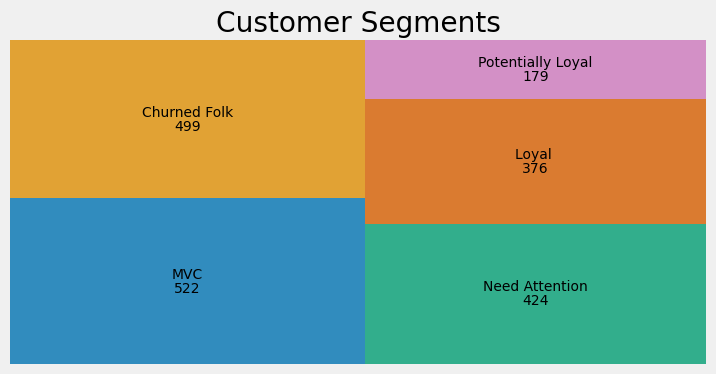

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

datamart.columns

# count the number of occurrences of each General_Segment value
segment_counts = datamart['General_Segment'].value_counts()

# create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 4))

# create the treemap using squarify and set colors for each segment
colors = sns.color_palette('colorblind', len(segment_counts))
squarify.plot(
    sizes=segment_counts.values,
    label=segment_counts.index,
    value=segment_counts,
    color=colors,
    alpha=0.8,
    ax=ax,
    text_kwargs={'fontsize': 10}
)

# set the axis properties
plt.axis('off')
plt.title('Customer Segments')

# show the treemap
plt.show()

## Further Analysis using customer demographic information

In [38]:
df_customer_datamart = pd.merge(df_customer, datamart, on='customerID', how='inner')
df_customer_datamart.head()

,customerID,customerName,customerAge,customerGender,customerLocation,customerEducation,customerIndustry,customerAuthorizedSignatories,customerGeneration,customerState,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,25965788,Travis Buchanan,53,Male,"00215 Brooks Tunnel Apt. 186\nJessicabury, DE ...",Master,IT,['Travis Buchanan'],Gen X,DE,1,192,746893.49,5,4,5,5.04.05.0,14,MVC
1,99599390,Patricia Haney,60,Other,"561 Thomas Manor\nGregorystad, ME 98366",PhD,Manufacturing,"['Patricia Haney', 'Michael Dennis']",Baby Boomers,ME,1,192,782220.05,5,4,5,5.04.05.0,14,MVC
2,83397893,Kimberly Hood,51,Female,"652 Atkinson Key Suite 623\nWest Miranda, NH 0...",High School,Healthcare,['Kimberly Hood'],Gen X,NH,2,192,754391.12,5,4,5,5.04.05.0,14,MVC
3,18621992,Chelsea Walton,59,Male,"118 Walker Ville\nMelissaland, AK 40847",Master,Finance,"['Chelsea Walton', 'Jennifer Watkins']",Baby Boomers,AK,1,192,712393.82,5,4,5,5.04.05.0,14,MVC
4,14714596,Melissa Cooper,20,Other,"8805 Thompson Village\nSouth Richard, WI 12607",High School,Automotive,['Melissa Cooper'],Gen Z,WI,2,192,714716.61,5,4,5,5.04.05.0,14,MVC


## Show drill-down data or sub-segments

Feel free to add more entries to list variable `sub_segment_columns=['customerEducation', 'customerIndustry', 'customerGeneration']`

In [39]:
import plotly.express as px
import pandas as pd

segment_groups = df_customer_datamart.groupby('General_Segment')
for segment, segment_data in segment_groups:
    sub_segment_columns=['customerEducation', 'customerIndustry', 'customerGeneration']
    group_data = segment_data.groupby(sub_segment_columns).size().reset_index(name='count')
    group_data["all"] = segment # in order to have a single root node
    fig = px.treemap(group_data,path=sub_segment_columns, values='count', title=segment)
    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()
    
for segment, segment_data in segment_groups:
    sub_segment_columns=['customerState']
    group_data = segment_data.groupby(sub_segment_columns).size().reset_index(name='count')
    group_data["all"] = segment # in order to have a single root node
    fig = px.treemap(group_data,path=sub_segment_columns, values='count', title=segment)
    fig.update_traces(root_color="lightgrey")
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

## Save data for further evaluation and action.

In [40]:
import os


transaction_data_file = config.get('OUTPUT','transaction_data',
                                 fallback='./data/output/customer_transaction_data.csv')

customer_data_file = config.get('OUTPUT','customer_data',
                                 fallback='./data/output/customer_data.csv')

os.makedirs(os.path.dirname(transaction_data_file),exist_ok=True)
os.makedirs(os.path.dirname(customer_data_file),exist_ok=True)

df_transactions.to_csv(transaction_data_file, index=False)
df_customer_datamart.to_csv(customer_data_file, index=False)

print(f"Data is saved to files\n{customer_data_file}\n{transaction_data_file}\n")

Data is saved to files
./data/output/customer_data.csv
./data/output/customer_transaction_data.csv

